In [77]:
from os.path import join
import gensim
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import wordnet

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pickle

In [27]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

In [44]:
datadir = join('dataset', 'ml-20m')


In [86]:
import gensim.downloader as api

wvmodel = api.load('word2vec-google-news-300')
wv = wvmodel.wv
del wvmodel

/work/modules/Ubuntu/14.04/amd64/common/anaconda3/latest/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/work/modules/Ubuntu/14.04/amd64/common/anaconda3/latest/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [90]:
cls2c = dict()
mv2c = dict()

with open(join(datadir, 'movies.csv'), 'r') as f:
    for i,line in enumerate(f):
        if i==0: continue
        line = line.strip()
        movieId,_ = line.split(',', maxsplit=1)
        _,genres = _.rsplit(',', maxsplit=1)
        movieId = int(movieId)
        mv2c[movieId] = []
        for _ in genres.split('|'):
            if _ not in cls2c: cls2c[_] = len(cls2c)
            mv2c[movieId].append(cls2c[_])

In [91]:
print(len(cls2c))

20


In [92]:
docs = []
tags_taken = set()
tags_untaken = set()

with open(join(datadir, 'tags.csv'), 'r') as f:
    for i,line in enumerate(f):
        if i==0: continue
        line = line.strip()
        userId,movieId,_ = line.split(',', maxsplit=2)
        tag,_ = _.rsplit(',', maxsplit=1)
        #if int(movieId) not in mv2c: continue
        
        doc = []
        for token in gensim.utils.simple_preprocess(tag):
            if token not in gensim.parsing.preprocessing.STOPWORDS:
                if token in tags_untaken: continue
                if token in tags_taken: 
                    tk = lemmatizer.lemmatize(token, wordnet.ADJ)
                    doc.append(tk)
                    continue
                    
                pos = get_wordnet_pos(token)
                if pos != wordnet.ADJ: 
                    if token not in tags_taken: tags_untaken.add(token)
                    continue
                    
                tk = lemmatizer.lemmatize(token, pos)
                if tk not in wv: 
                    if token not in tags_taken: tags_untaken.add(token)
                    continue
                
                doc.append(tk)
                if tk not in tags_taken: tags_taken.add(tk)
        if doc:
            docs.append(doc)

In [93]:
print(len(docs))

74672


In [94]:
dictionary = gensim.corpora.Dictionary(docs)
#dictionary.filter_extremes(no_below=1, no_above=0.2, keep_n=10000)

In [95]:
len(dictionary)

925

In [96]:
t2c = dict()
t2v = dict()

with open(join(datadir, 'tags.csv'), 'r') as f:
    for i,line in enumerate(f):
        if i==0: continue
        line = line.strip()
        userId,movieId,_ = line.split(',', maxsplit=2)
        tag,_ = _.rsplit(',', maxsplit=1)
        movieId = int(movieId)
        #if int(movieId) not in mv2c: continue
        
        for token in gensim.utils.simple_preprocess(tag):
            if token not in gensim.parsing.preprocessing.STOPWORDS:
                tk = lemmatizer.lemmatize(token, wordnet.ADJ)
                if tk not in dictionary.token2id: continue
                    
                t = dictionary.token2id[tk]
                if t not in t2v: t2v[t] = set()
                if movieId not in t2v[t]: t2v[t].add(movieId)
                if t not in t2c: t2c[t] = set()
                for c in mv2c[movieId]:
                    if c not in t2c[t]: t2c[t].add(c)

In [97]:
len(t2c)

925

In [98]:
vecs = []
for t in range(len(dictionary)):
    tag = dictionary[t]
    vecs.append(wv[tag])

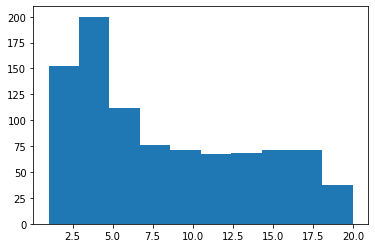

In [99]:
plt.hist([len(cs) for t,cs in t2c.items()])
plt.show()

In [104]:
len(mv2c)

27278

In [103]:
with open(join('dataset', 'movielens.pkl'), 'wb') as f:
    pickle.dump([np.array(vecs), dictionary.token2id, dictionary.id2token, t2c, cls2c, t2v, mv2c], f)